In [31]:
# download photons dataset
!curl -L -o photons.hdf5 https://cernbox.cern.ch/remote.php/dav/public-files/AtBT8y4MiQYFcgc/SinglePhotonPt50_IMGCROPS_n249k_RHv1.hdf5

# download electrons dataset
!curl -L -o electrons.hdf5 https://cernbox.cern.ch/remote.php/dav/public-files/FbXw3V4XNyYB3oA/SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  114M  100  114M    0     0  4035k      0  0:00:28  0:00:28 --:--:--  934k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  122M  100  122M    0     0  22.5M      0  0:00:05  0:00:05 --:--:-- 25.4M


In [7]:
import h5py

# open photons dataset
with h5py.File('photons.hdf5', 'r') as f:
    X, y = f['X'], f['y']

    print(X)
    print(y)

# open electrons dataset
with h5py.File('electrons.hdf5', 'r') as f:
    X, y = f['X'], f['y']

    print(X)
    print(y)

<HDF5 dataset "X": shape (249000, 32, 32, 2), type "<f4">
<HDF5 dataset "y": shape (249000,), type "<f4">
<HDF5 dataset "X": shape (249000, 32, 32, 2), type "<f4">
<HDF5 dataset "y": shape (249000,), type "<f4">


In [8]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import h5py
import matplotlib.pyplot as plt

# device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'running on {device}')

running on cuda


In [9]:
class ParticleDataset(Dataset):
    def __init__(self, photon_file, electron_file, augment=True, transform=None):
        # load photon data
        with h5py.File(photon_file, 'r') as f:
            photon_X = f['X'][:]
            photon_y = f['y'][:]

        # load electron data
        with h5py.File(electron_file, 'r') as f:
            electron_X = f['X'][:]
            electron_y = f['y'][:]

        # combine datasets
        self.X = np.concatenate([photon_X, electron_X], axis=0)
        self.y = np.concatenate([photon_y, electron_y], axis=0)

        # compute mean and std for normalization
        self.mean = self.X.mean(axis=(0, 1, 2))
        self.std = self.X.std(axis=(0, 1, 2))

        self.augment = augment
        self.transform = transform

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        # transpose to match PyTorch's channel-first format
        x = self.X[idx].transpose(2, 0, 1).copy()

        # normalize the data
        x = (x - self.mean[:, np.newaxis, np.newaxis]) / self.std[:, np.newaxis, np.newaxis]

        # simple augmentations
        if self.augment:
            # random rotation
            if np.random.random() < 0.3:
                x = np.ascontiguousarray(np.rot90(x, k=np.random.randint(1, 4), axes=(1, 2)))

            # small noise injection
            if np.random.random() < 0.3:
                noise = np.random.normal(0, 0.1, x.shape)
                x = x + noise

        return torch.FloatTensor(x), torch.FloatTensor([self.y[idx]])

In [10]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels)
        )
        self.downsample = downsample
        self.relu = nn.ReLU()

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)

        if self.downsample:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)
        return out

In [11]:
class ResNet(nn.Module):
    def __init__(self, block, in_channels=2, num_classes=1):
        super(ResNet, self).__init__()
        # initial convolution
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        # residual blocks
        self.layer1 = self._make_layer(block, 64, 64, blocks=3, stride=1)
        self.layer2 = self._make_layer(block, 64, 128, blocks=4, stride=2)
        self.layer3 = self._make_layer(block, 128, 256, blocks=6, stride=2)
        self.layer4 = self._make_layer(block, 256, 512, blocks=3, stride=2)

        # global average pooling
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        # fully connected layer
        # self.fc = nn.Sequential(
        #     nn.Linear(512, 256),
        #     nn.ReLU(),
        #     nn.Dropout(0.2),
        #     nn.Linear(256, 128),
        #     nn.ReLU(),
        #     nn.Dropout(0.2),
        #     nn.Linear(128, num_classes)
        # )
    
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, in_channels, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )

        layers = []
        layers.append(block(in_channels, out_channels, stride, downsample))

        for _ in range(1, blocks):
            layers.append(block(out_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = torch.sigmoid(self.fc(x))

        return x

In [12]:
# learning rate scheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=20):
    # training loop with validation
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        # training phase
        model.train()
        total_train_loss = 0
        total_train_correct = 0
        total_train_samples = 0

        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward pass
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)

            # backward pass and optimize
            loss.backward()
            optimizer.step()

            # calculate training accuracy
            predicted = (outputs > 0.5).float()
            total_train_correct += (predicted == batch_y).float().sum().item()
            total_train_samples += batch_y.size(0)
            total_train_loss += loss.item()

        # validation phase
        model.eval()
        total_val_loss = 0
        total_val_correct = 0
        total_val_samples = 0

        with torch.no_grad():
            for batch_x, batch_y in val_loader:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)

                outputs = model(batch_x)
                loss = criterion(outputs, batch_y)

                # calculate validation accuracy
                predicted = (outputs > 0.5).float()
                total_val_correct += (predicted == batch_y).float().sum().item()
                total_val_samples += batch_y.size(0)
                total_val_loss += loss.item()

        # calculate metrics
        train_loss = total_train_loss / len(train_loader)
        val_loss = total_val_loss / len(val_loader)
        train_accuracy = total_train_correct / total_train_samples
        val_accuracy = total_val_correct / total_val_samples

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)

        print('=' * 50)
        print(f'last lr (before scheduler step) = {scheduler.get_last_lr()}')
        scheduler.step(val_loss)
        print(f'last lr (after scheduler step) = {scheduler.get_last_lr()}')
        
        print(f'epoch [{epoch+1}/{num_epochs}]')
        print(f'train loss: {train_loss:.4f}, train accuracy: {train_accuracy:.4f}')
        print(f'val loss: {val_loss:.4f}, val accuracy: {val_accuracy:.4f}')

    return train_losses, val_losses, train_accuracies, val_accuracies

In [13]:
import os

def plot_sample(dataset, idx, title):
    x, y = dataset[idx]
    energy, time = x[0], x[1] # channels: energy, time
    label = 'Photon' if y.item() == 1 else 'Electron'

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(energy, cmap='viridis')
    axes[0].set_title(f'Energy - {label}')
    axes[1].imshow(time, cmap='plasma')
    axes[1].set_title(f'Time - {label}')
    plt.suptitle(title)
    plt.show()
    
def main():
    # create dataset
    dataset = ParticleDataset('photons.hdf5', 'electrons.hdf5')

    # split dataset
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    # plot samples
    plot_sample(train_dataset, 7, 'Sample 1')
    plot_sample(train_dataset, 24, 'Sample 2')
    plot_sample(train_dataset, 51, 'Sample 3')
    plot_sample(train_dataset, 75, 'Sample 4')
    plot_sample(train_dataset, 103, 'Sample 5')

    # create data loaders
    train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)

    # initialize model
    model = ResNet(ResidualBlock).to(device)

    if os.path.isfile('electron_photon_classifier.pth'):
        print('found `electron_photon_classifier.pth`, loading weights into memory')
        model.load_state_dict(torch.load('electron_photon_classifier.pth'))

    # loss and optimizer
    criterion = nn.BCELoss() # Binary Cross Entropy (BCE) loss for binary classification
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-5)
    scheduler = ReduceLROnPlateau(optimizer,
                              mode='min',
                              factor=0.1,
                              patience=2)

    print('beginning training loop...')
    # train the model
    train_losses, val_losses, train_accuracies, val_accuracies = train_model(
        model, train_loader, val_loader, criterion, optimizer, scheduler
    )

    print('plotting training metrics')
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1) 
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.title('Accuracy Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()

    plt.savefig('loss_accuracy_curves.png')
    plt.show()

    # save model weights
    torch.save(model.state_dict(), 'electron_photon_classifier.pth')

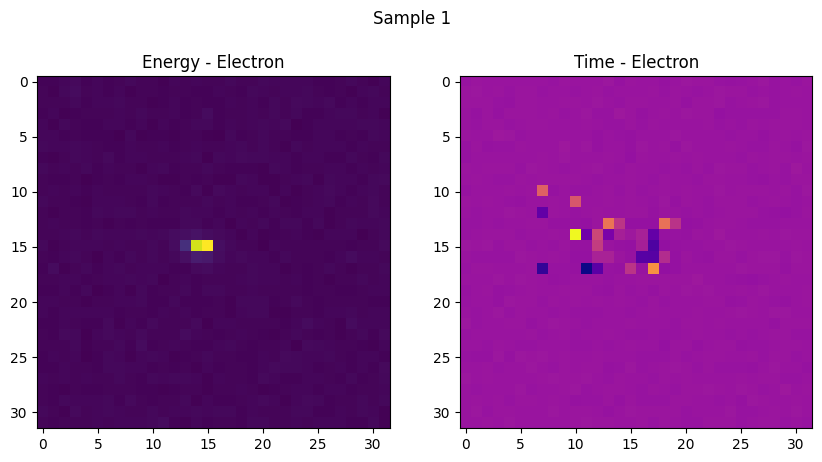

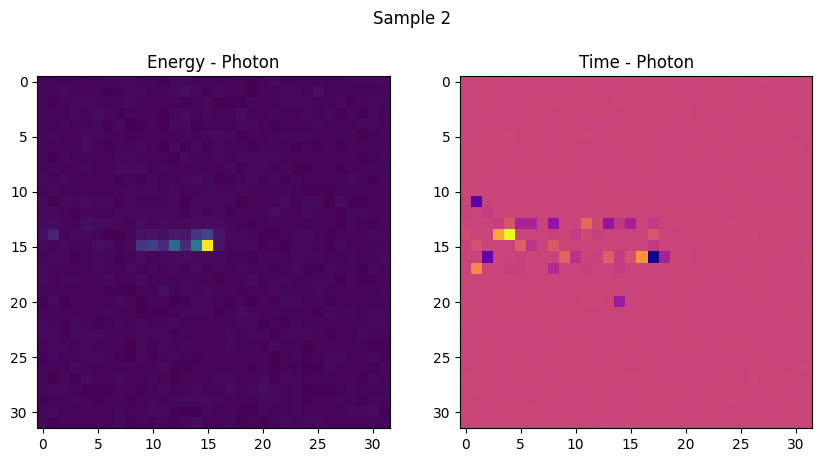

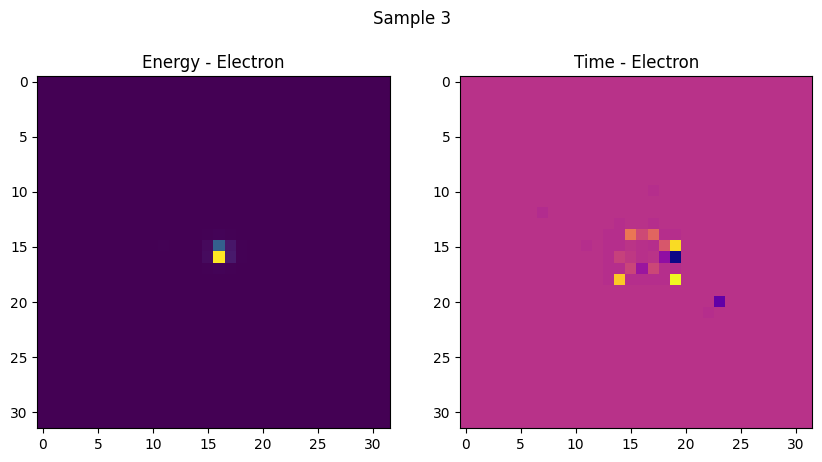

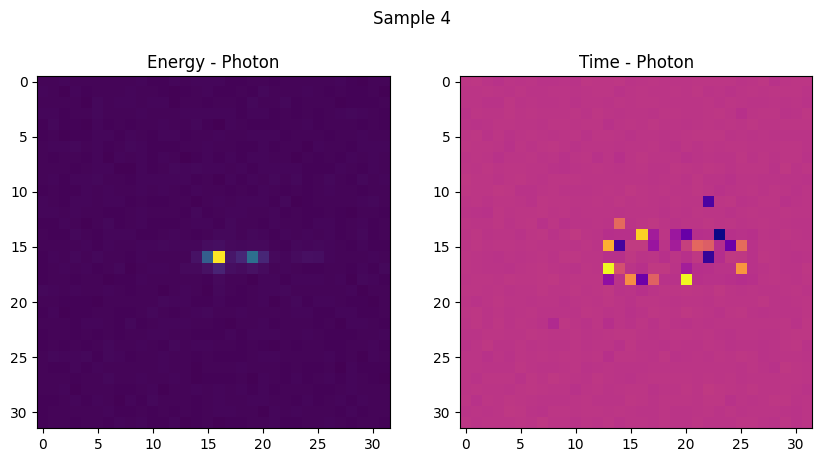

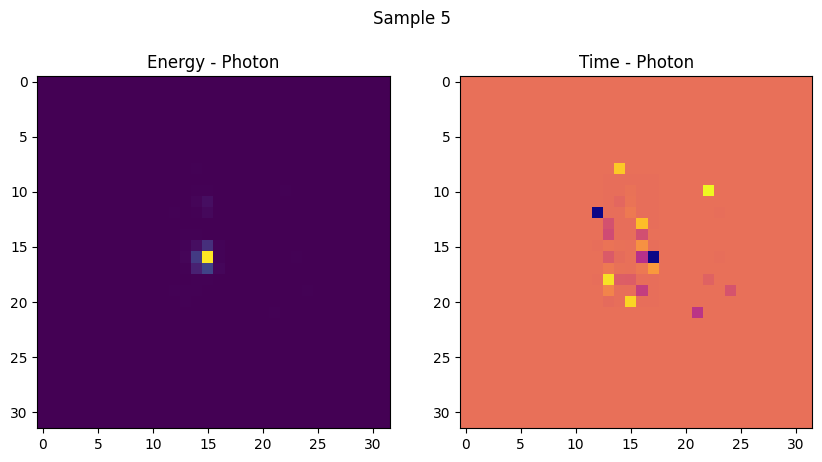

found `electron_photon_classifier.pth`, loading weights into memory
beginning training loop...
last lr (before scheduler step) = [0.1]
last lr (after scheduler step) = [0.1]
epoch [1/20]
train loss: 0.5896, train accuracy: 0.6933
val loss: 0.6126, val accuracy: 0.6750
last lr (before scheduler step) = [0.1]
last lr (after scheduler step) = [0.1]
epoch [2/20]
train loss: 0.5869, train accuracy: 0.6944
val loss: 0.6131, val accuracy: 0.6820
last lr (before scheduler step) = [0.1]
last lr (after scheduler step) = [0.1]
epoch [3/20]
train loss: 0.5849, train accuracy: 0.6963
val loss: 0.6052, val accuracy: 0.6881
last lr (before scheduler step) = [0.1]
last lr (after scheduler step) = [0.1]
epoch [4/20]
train loss: 0.5833, train accuracy: 0.6979
val loss: 0.5890, val accuracy: 0.6987
last lr (before scheduler step) = [0.1]
last lr (after scheduler step) = [0.1]
epoch [5/20]
train loss: 0.5822, train accuracy: 0.6997
val loss: 0.5905, val accuracy: 0.6926
last lr (before scheduler step) = [

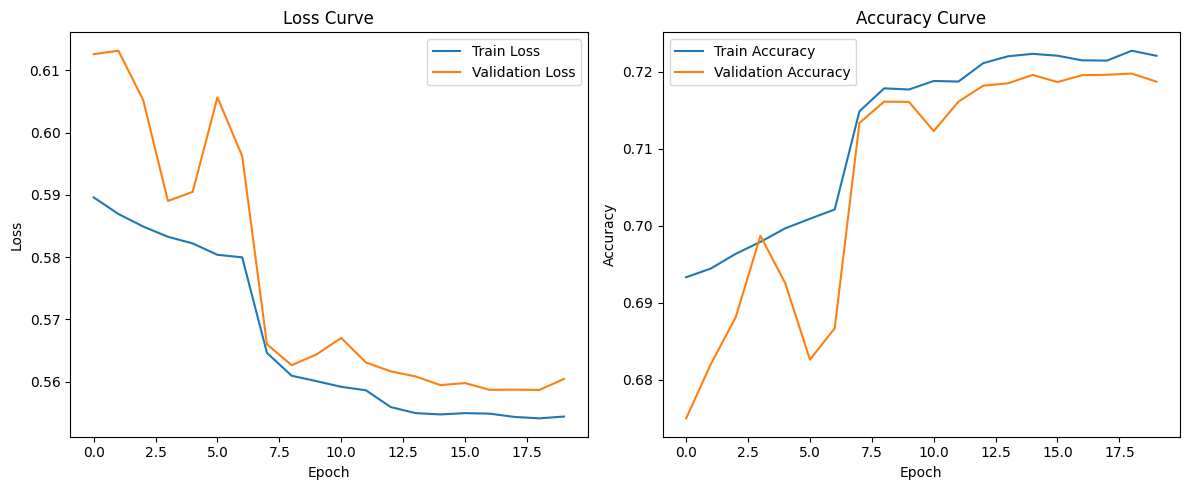

In [14]:
if __name__ == '__main__':
    main()